In [2]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay, 
    roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score,
    fbeta_score # UPGRADE: Added for high-recall optimization
)

In [3]:
os.makedirs('models', exist_ok=True)

# 1. LOAD PREPARED DATA
# Using the synchronized, cleaned SMOTE-ENN files
X_train = pd.read_csv('X_train_final.csv')
y_train = pd.read_csv('y_train_final.csv').values.ravel()
X_test = pd.read_csv('X_test_final.csv')

# Binarizing the test target (Threshold 0.7 matches Milestone 3 logic) [cite: 10, 11]
y_test_cont = pd.read_csv('y_test_final.csv').values.ravel()
y_test = (y_test_cont > 0.7).astype(int)

print(f"Dataset Loaded. Cleaned Training Samples: {len(X_train)}")
print(f"Features for Training: {X_train.shape[1]}")


Dataset Loaded. Cleaned Training Samples: 8599
Features for Training: 39


In [4]:
# Random Forest Pipeline
rf_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight="balanced"
    ))
])

# XGBoost Pipeline
xgb_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss",
        scale_pos_weight=2
    ))
])

models = {
    "Random Forest": rf_pipeline,
    "XGBoost": xgb_pipeline
}



Training model: Random Forest
Saved model to: models/random_forest.pkl
                       precision    recall  f1-score   support

        Non-Habitable       1.00      1.00      1.00      1083
Potentially Habitable       0.33      0.17      0.22         6

             accuracy                           0.99      1089
            macro avg       0.66      0.58      0.61      1089
         weighted avg       0.99      0.99      0.99      1089



<Figure size 800x600 with 0 Axes>

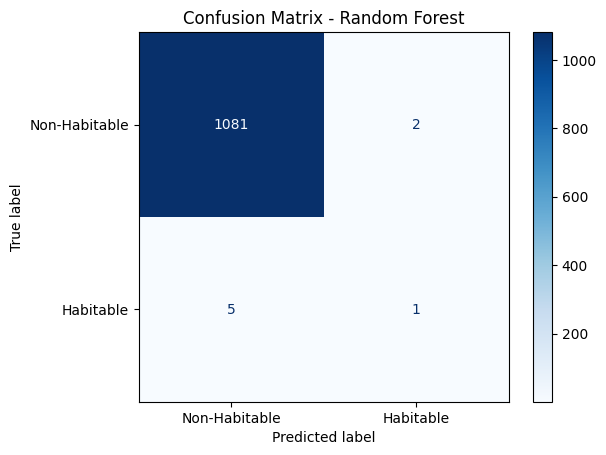


Training model: XGBoost


C:\Users\Anjali\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\xgboost\training.py:199: UserWarning: [19:30:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Saved model to: models/xgboost.pkl
                       precision    recall  f1-score   support

        Non-Habitable       1.00      1.00      1.00      1083
Potentially Habitable       0.38      0.50      0.43         6

             accuracy                           0.99      1089
            macro avg       0.69      0.75      0.71      1089
         weighted avg       0.99      0.99      0.99      1089



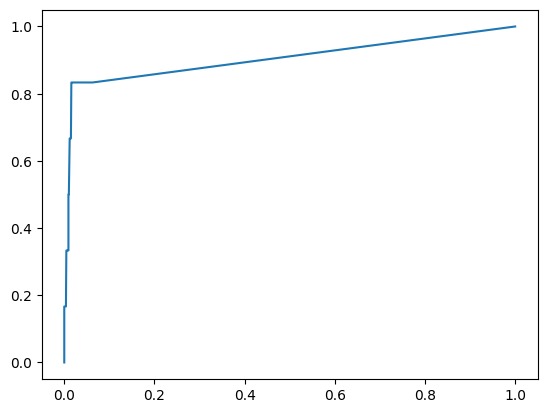

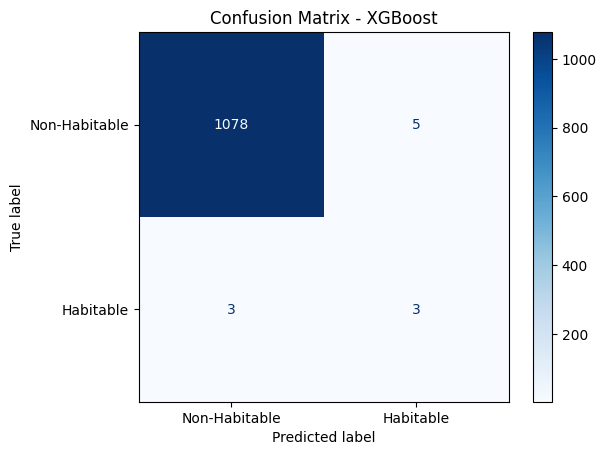

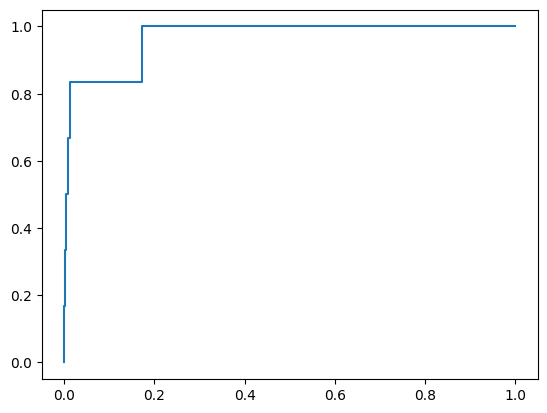

In [5]:
results = []
plt.figure(figsize=(8, 6))

for model_name, pipeline in models.items():
    print(f"\nTraining model: {model_name}")
    
    # Train
    pipeline.fit(X_train, y_train)
    
    # Save model
    model_path = f"models/{model_name.lower().replace(' ', '_')}.pkl"
    joblib.dump(pipeline, model_path)
    print("Saved model to:", model_path)
    
    # Predictions
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    f2 = fbeta_score(y_test, y_pred, beta=2, zero_division=0)
    
    results.append({
        "Model": model_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1,
        "F2-score": f2
    })
    
    # Classification Report
    print(classification_report(
        y_test,
        y_pred,
        target_names=["Non-Habitable", "Potentially Habitable"]
    ))
    
    # Confusion Matrix
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        display_labels=["Non-Habitable", "Habitable"],
        cmap="Blues"
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")


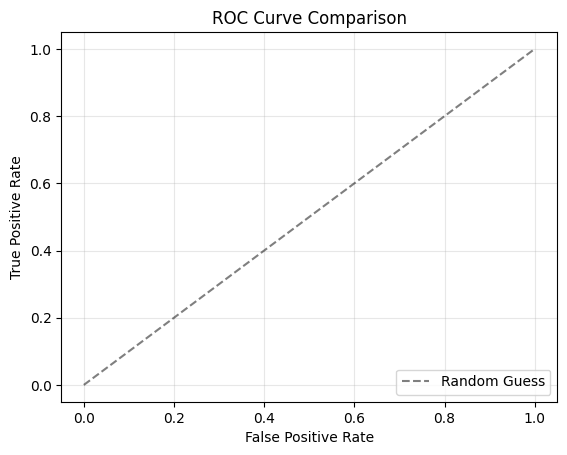

MODEL PERFORMANCE SUMMARY
        Model  Accuracy  Precision   Recall  F1-score  F2-score
      XGBoost  0.992654   0.375000 0.500000  0.428571  0.468750
Random Forest  0.993572   0.333333 0.166667  0.222222  0.185185


In [6]:
# 4. FINALIZE ROC CURVE COMPARISON [cite: 73]
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# 5. MODEL COMPARISON SUMMARY [cite: 87, 88]
comparison_df = pd.DataFrame(results)

print("=" * 50)
print("MODEL PERFORMANCE SUMMARY")
print("=" * 50)
print(
    comparison_df
    .sort_values(by="F2-score", ascending=False)
    .to_string(index=False)
)
